In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

%load_ext autoreload

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

from tensorflow.keras import layers,models,utils
from tensorflow.keras import optimizers

from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

In [5]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [5]:
#import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[22. 28.]
 [49. 64.]]


In [6]:
conv_base = VGG16(weights='imagenet',include_top=False,input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.


### Extracting features using the pretrained convolutional base

In [7]:
base_dir = './../data/cats_and_dogs_small/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [8]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [9]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [10]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [12]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',metrics=['acc'])
history = model.fit(train_features, train_labels, epochs=30, batch_size=20,
validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 2000 samples, validate on 1000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
2000/2000 [==============================] - 3s 2ms/sample - loss: 0.6083 - acc: 0.6635 - val_loss: 0.4451 - val_acc: 0.8250
Epoch 2/30
2000/2000 [==============================] - 1s 281us/sample - loss: 0.4263 - acc: 0.8035 - val_loss: 0.3584 - val_acc: 0.8630
Epoch 3/30
2000/2000 [==============================] - 1s 279us/sample - loss: 0.3586 - acc: 0.8505 - val_loss: 0.3200 - val_acc: 0.8780
Epoch 4/30
2000/2000 [==============================] - 1s 281us/sample - loss: 0.3149 - acc: 0.8755 - val_loss: 0.2964 - val_acc: 0.8930
Epoch 5/30
2000/2000 [==============================] - 1s 283us/sample - loss: 0.2836 - acc: 0.8885 - val_loss: 0.2827 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 1s 291us/sample - loss: 0.2660 - acc: 0.8920 

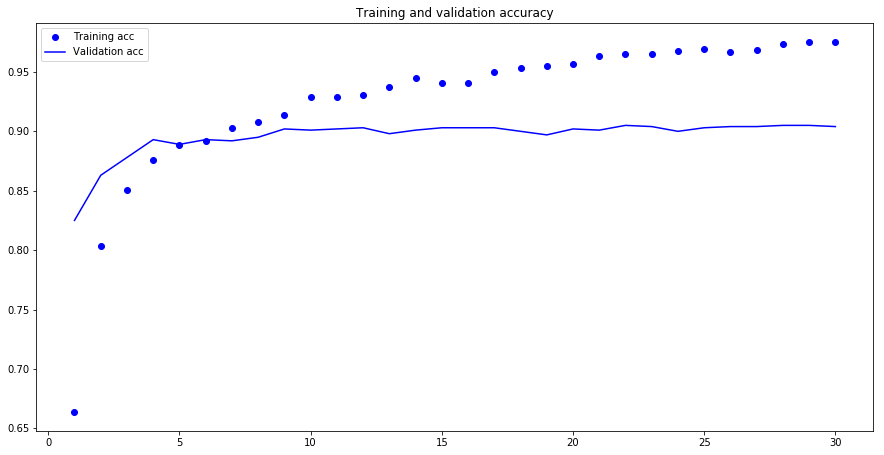

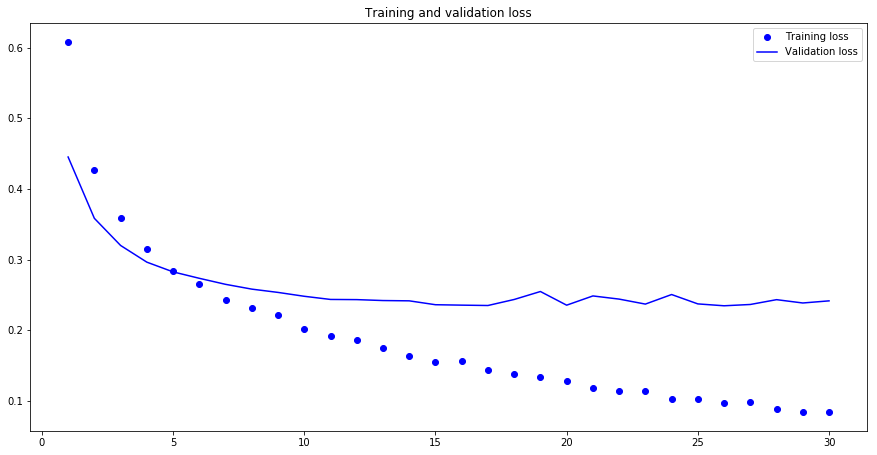

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,7.5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(15,7.5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Adding a densely connected classifier on top of the convolutional base

In [8]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   zoom_range=0.2, horizontal_flip=True,)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                    batch_size=20, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,target_size=(150, 150),
                                                        batch_size=20,class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',metrics=['acc'])

In [14]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 25s 253ms/step - loss: 0.5950 - acc: 0.6855 - val_loss: 0.4519 - val_acc: 0.8210
Epoch 2/30
100/100 [==============================] - 23s 230ms/step - loss: 0.4903 - acc: 0.7785 - val_loss: 0.3789 - val_acc: 0.8580
Epoch 3/30
100/100 [==============================] - 23s 234ms/step - loss: 0.4321 - acc: 0.8105 - val_loss: 0.3349 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 23s 232ms/step - loss: 0.4190 - acc: 0.8040 - val_loss: 0.3099 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 23s 231ms/step - loss: 0.3810 - acc: 0.8290 - val_loss: 0.3025 - val_acc: 0.8780
Epoch 6/30
100/100 [==============================] - 23s 231ms/step - loss: 0.3620 - acc: 0.8490 - val_loss: 0.2950 - val_acc: 0.8770
Epoch 7/30
100/100 [==============================] - 23s 231ms/step - loss: 0.3525 - acc: 0.8530 - val_loss: 0.2799 - val_acc: 0.8800
Epoch 8

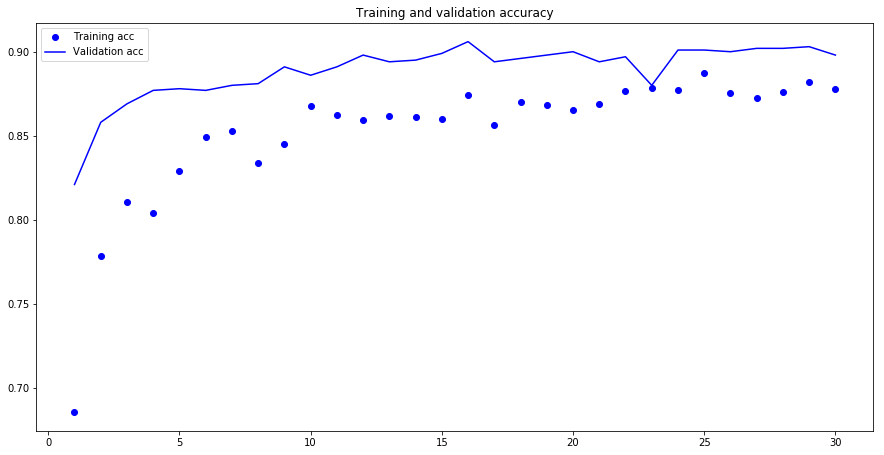

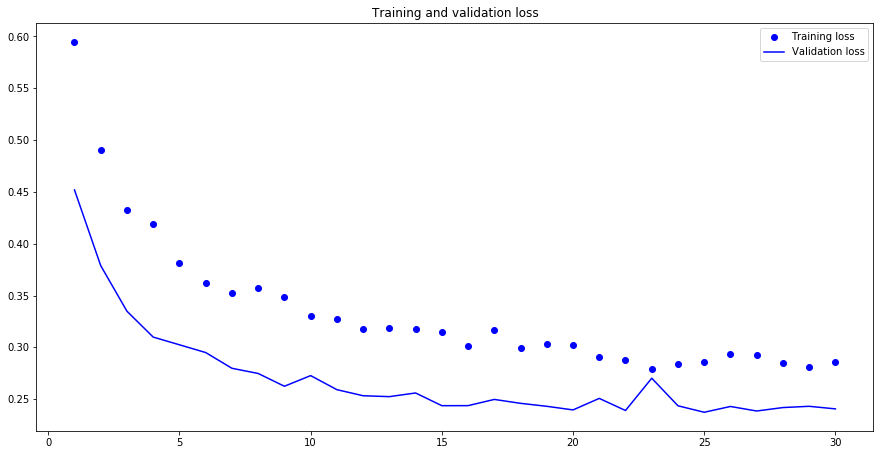

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,7.5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(15,7.5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Fine tuning the model

In [16]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [17]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy',metrics=['acc'])

In [19]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=validation_generator, validation_steps=50)

Epoch 1/100
100/100 [==============================] - 27s 270ms/step - loss: 0.3238 - acc: 0.8665 - val_loss: 0.2189 - val_acc: 0.9100
Epoch 2/100
100/100 [==============================] - 27s 271ms/step - loss: 0.2866 - acc: 0.8810 - val_loss: 0.2566 - val_acc: 0.8890
Epoch 3/100
100/100 [==============================] - 27s 272ms/step - loss: 0.2333 - acc: 0.8980 - val_loss: 0.2033 - val_acc: 0.9170
Epoch 4/100
100/100 [==============================] - 27s 272ms/step - loss: 0.2169 - acc: 0.9100 - val_loss: 0.1951 - val_acc: 0.9260
Epoch 5/100
100/100 [==============================] - 27s 273ms/step - loss: 0.1921 - acc: 0.9165 - val_loss: 0.1963 - val_acc: 0.9220
Epoch 6/100
100/100 [==============================] - 27s 273ms/step - loss: 0.1768 - acc: 0.9300 - val_loss: 0.1771 - val_acc: 0.9270
Epoch 7/100
100/100 [==============================] - 27s 272ms/step - loss: 0.1792 - acc: 0.9270 - val_loss: 0.2048 - val_acc: 0.9280
Epoch 8/100
100/100 [===========================

100/100 [==============================] - 28s 275ms/step - loss: 0.0141 - acc: 0.9960 - val_loss: 0.4246 - val_acc: 0.9350
Epoch 76/100
100/100 [==============================] - 27s 273ms/step - loss: 0.0307 - acc: 0.9920 - val_loss: 0.4301 - val_acc: 0.9350
Epoch 77/100
100/100 [==============================] - 27s 274ms/step - loss: 0.0302 - acc: 0.9870 - val_loss: 0.3492 - val_acc: 0.9360
Epoch 78/100
100/100 [==============================] - 27s 275ms/step - loss: 0.0246 - acc: 0.9920 - val_loss: 0.4253 - val_acc: 0.9300
Epoch 79/100
100/100 [==============================] - 27s 274ms/step - loss: 0.0222 - acc: 0.9945 - val_loss: 0.3380 - val_acc: 0.9400
Epoch 80/100
100/100 [==============================] - 27s 274ms/step - loss: 0.0284 - acc: 0.9925 - val_loss: 0.4103 - val_acc: 0.9310
Epoch 81/100
100/100 [==============================] - 27s 274ms/step - loss: 0.0271 - acc: 0.9920 - val_loss: 0.3813 - val_acc: 0.9270
Epoch 82/100
100/100 [==============================] 

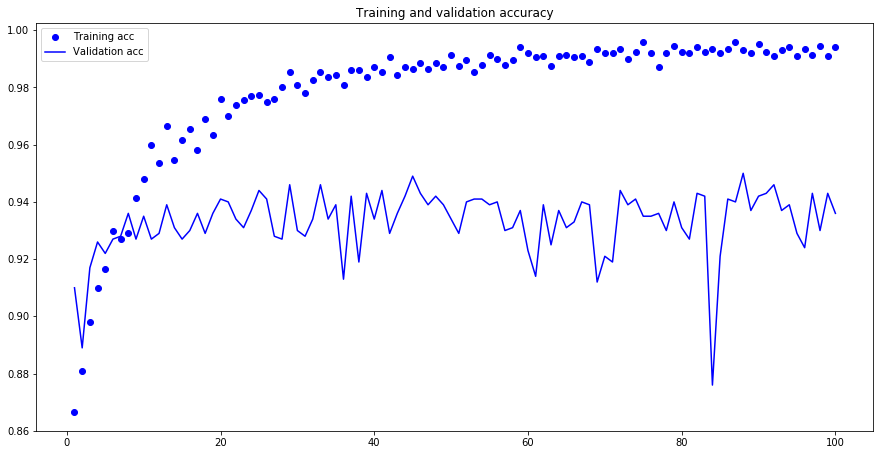

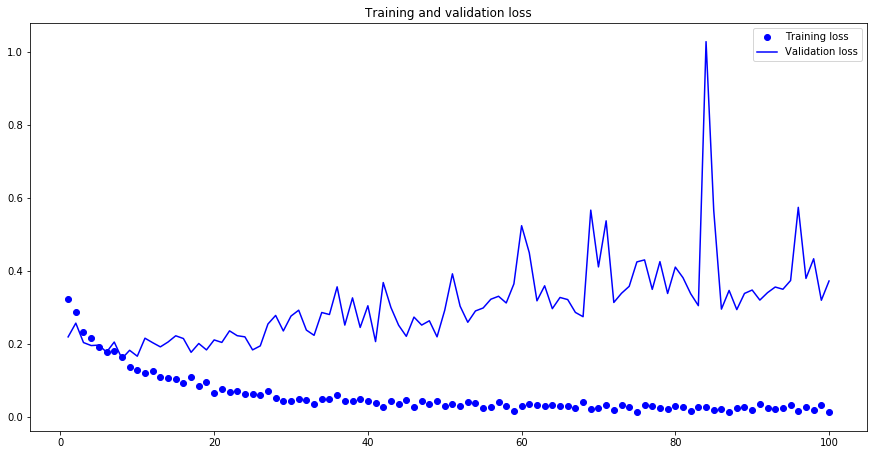

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(15,7.5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(15,7.5))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

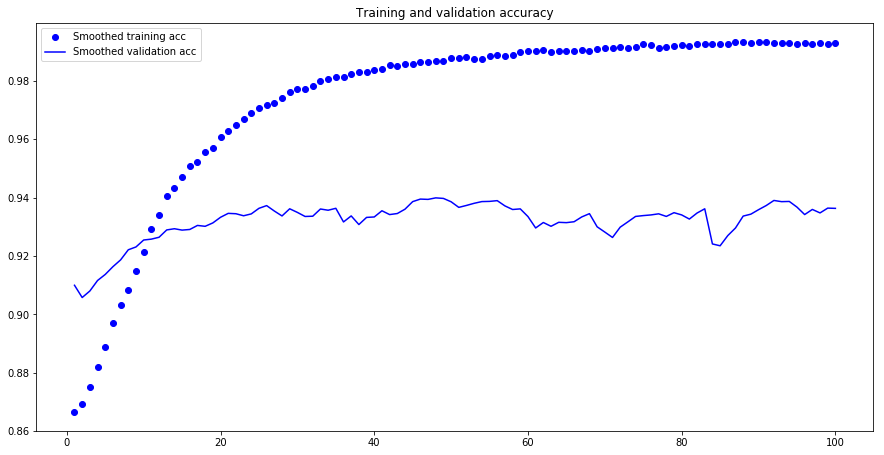

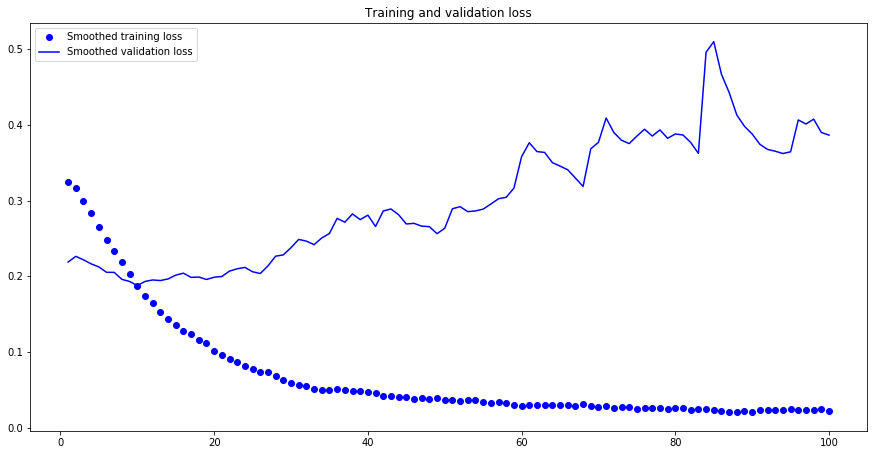

In [22]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.figure(figsize=(15,7.5)) 
plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize=(15,7.5)) 
plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.939
